In [1]:
import pandas as pd
from gensim.models import FastText


C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_hdf("../datasets/funny.h5", key="funny")

In [3]:
model_sent = FastText.load("../models/subreddit_level/fasttext_funny_senti.bin")

In [4]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])

In [5]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [47]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"]   

    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [48]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [49]:
woman_terms_freq, man_terms_freq

([['she', 'girl', 'woman', 'sister', 'her', 'female', 'daughter', 'hers'],
  [67929, 8010, 14012, 2154, 19794, 2207, 2535, 118]],
 [['he', 'his', 'man', 'brother', 'male', 'son', 'boy', 'him'],
  [137335, 48155, 28282, 3622, 2641, 3603, 5359, 120]])

In [50]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [51]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'her', 'girl', 'herself', 'lady', 'girlfriend', 'boyfriend', 'mom', 'gf', 'wife']
Top 10 (man) ['he', 'his', 'guy', 'himself', 'dude', 'brother', 'son', 'dad', 'stepbrother', 'quitter']


In [52]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
123,hell,0.020,0.918,0.565
84,dead,0.052,0.454,0.194
91,bastards,0.082,0.680,0.422
72,demented,0.088,0.787,0.309
180,worried,0.094,0.824,0.395


In [53]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
188,revenge,0.230,0.940,0.627
123,hell,0.020,0.918,0.565
181,stab,0.167,0.882,0.595
165,madman,0.135,0.880,0.312
81,mad,0.219,0.873,0.277


In [54]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
36,highness,0.740,0.670,0.931
65,decide,0.656,0.540,0.855
99,courage,0.830,0.728,0.849
128,cheer,0.938,0.784,0.845
23,father,0.812,0.333,0.824


In [55]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
136,afraid,0.010,0.775,0.245
166,horrified,0.040,0.885,0.368
240,betray,0.042,0.870,0.536
76,divorce,0.042,0.700,0.385
72,deathbed,0.051,0.652,0.311


In [56]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
94,bang,0.265,0.951,0.740
228,excite,0.823,0.950,0.668
200,panicked,0.100,0.949,0.260
73,sexy,0.865,0.945,0.802
203,yelling,0.323,0.939,0.565


In [57]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
205,overbearing,0.323,0.833,0.861
229,parent,0.812,0.357,0.860
147,decide,0.656,0.540,0.855
128,father,0.812,0.333,0.824
73,sexy,0.865,0.945,0.802


In [58]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.04999367655249234 0.02903842316903369 0.02513532667780562


In [59]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.06376119502074692 0.03722732754363705 0.020626816432906966


In [60]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()

    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))

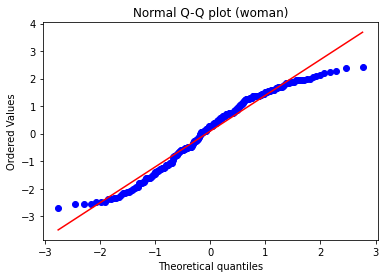

kolmogorv KstestResult(statistic=0.5582847477455467, pvalue=1.4721870635875709e-71)


In [61]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

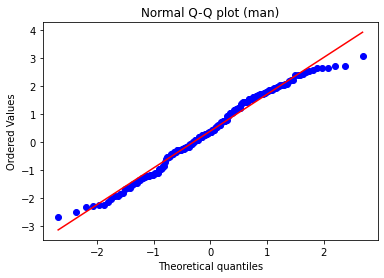

kolmogorv KstestResult(statistic=0.5716170071250997, pvalue=2.890879989496847e-59)


In [62]:
check_normal_dist(df_NRC_man, "arousal","man")

In [63]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    import math
    import statistics

    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("welsh")
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [64]:
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=3.011334, p=0.003
Different distributions (reject H0)
0.289709001792402 Cohens D
242 190
welsh
Statistics=0.183379, p=0.855
Same distribution (fail to reject H0)
242 190
welsh
Statistics=-1.162982, p=0.246
Same distribution (fail to reject H0)
242 190


In [65]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.5449736842105265 0.4784105263157895 0.4890368421052632
0.5491818181818184 0.5311446280991737 0.4718842975206614
